In [19]:
'''
Author: Ludovic
Input: sensor_type, csv_file_name, output_name
To change: time_reference, name of the output file

'''

####### script
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import processFile
import datetime as dt
import pandas as pd
import csv
from sklearn.preprocessing import maxabs_scale
from collections import Counter
%matplotlib inline

# reference
time_reference = dt.datetime(2016,3,28,0,01,00,000000)

# enter output name
output_name = "Bed2_out"

# enter sensor type (pressure, accelerometer, humidity, magnetometer, temperature)
#value_type = sys.argv[1]
value_type = "accelerometer"

# indicate if file type is new (with sensor id) or old (first version of the csv files): True or False
new = True

# indicate if hour should be a feature or not
hour_bool = True

# enter file name
#file = 'C:\Users\Ludovic\Documents\Capstone\Capstone_MachineLearning\example.csv'
#file = sys.argv[2]
file = 'C:\Users\Ludovic\Documents\Capstone\Capstone_MachineLearning\Bed2.csv'

time, data = processFile.openFile(file, value_type, new, True)
print 'data.shape: ' , data.shape


if value_type in {"accelerometer", "magnetometer"}:
    dataX = data[:,0]
    dataY = data[:,1]
    dataZ = data[:,2]
    dataN = np.sqrt(dataX*dataX+dataY*dataY+dataZ*dataZ)
    
elif value_type == "temperature":
    dataN = data[:,0] # ambient_temp
    #object_temp = data[:,1]
    
elif value_type == "humidity":
    dataN = data
    
else:
    print "invalid value_type"


########## define features

def mean(vector):
    return np.mean(vector)

def maxi(vector):
    return np.max(vector)

def mini(vector):
    return np.min(vector)

def max_minus_min(vector):
    return np.max(vector) - np.min(vector)

def std(vector):
    return np.std(vector)

def variance(vector):
    return np.var(vector)

def RMS(vector):
    # returns Root Mean Square
    return np.sqrt(np.mean(np.square(vector)))

def hour_of_day(time_stamp):
    # returns the hour of the day of the time window
    if type(time_stamp) == str:
        return 
    else:
        return time_stamp.hour

def end_minus_start(vector):
    # returns the last element of the vector minus the first element of the vector
    # useful for slow evolutions (eg temperature
    if len(vector) >0:
    	return vector.iloc[-1]-vector.iloc[0]
    else:
    	return float("nan")

def update_time_window_start(time):
    return time + dt.timedelta(0,60)


########### initialization

print "Initializing..."

temp = list(zip(time,dataN))  #temporary list to prepare for the data frame (using pandas)
df = pd.DataFrame(data = temp, columns = ['Time', 'Data']) #data frame (using pandas)


Opening file...
data.shape:  (1528200L, 3L)
Initializing...


In [20]:
df.head(3)

,Time,Data
0,2016-03-28 17:08:55.405000,1.129774
1,2016-03-28 17:08:55.793999,0.000000
2,2016-03-28 17:08:55.795999,1.136071


In [21]:

########## preprocess data 

print "Preprocessing data..."
if value_type in {"accelerometer", "magnetometer"}:
    df2 = df[df['Data']!=0]

elif value_type == "temperature":
    df2 = df[df['Data']<80]

elif value_type == "humidity":
    c = Counter(df.Data)
    value_to_remove = c.most_common(1)[0][0] #value that appears the most frequently
    df2 = df[(df['Data']!= value_to_remove) & (df['Data'] <10)]
    maxabs_scale(df2.Data, copy = False)
else:
    print "invalid value type"

print "Data Preprocessed"

########## initialize for featurizing

time_window_start = time_reference 
feature_list = []
# number of data points
n = df2.shape[0]
# counter, to determine how many data points from the file have been processed (so that we know if we should stop or not)
count = 0


Preprocessing data...
Data Preprocessed


<function matplotlib.pyplot.show>

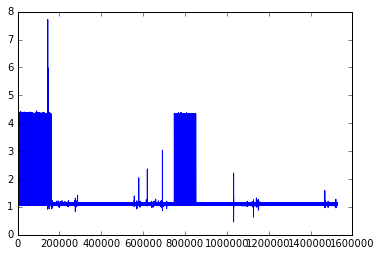

In [22]:
plt.plot(df2.Data)
plt.show

In [24]:
if value_type == "humidity":
    maxabs_scale(df2.Data, copy = False)

In [ ]:
######### create feature for each time window
print "Creating features..."

tracker_25 = 0
tracker_50 = 0
tracker_75 = 0

if hour_bool:
    while count < n:    
        temp = df2[(df2['Time'] >= time_window_start) & (df2['Time'] < (time_window_start + dt.timedelta(0,60)))]
        count = count + len(temp.Data)
        feature_list.append([time_window_start,mean(temp.Data),maxi(temp.Data),mini(temp.Data), max_minus_min(temp.Data),
         std(temp.Data), variance(temp.Data), RMS(temp.Data),end_minus_start(temp.Data),hour_of_day(time_window_start)])
        # update time window
        time_window_start = update_time_window_start(time_window_start)
        if ((count/float(n) > .25) and (tracker_25 == 0)): 
            tracker_25 = 1
            print "25 percent reached"
        if ((count/float(n) > .5) and (tracker_50 == 0)): 
            tracker_50 = 1
            print "50 percent reached"
        if ((count/float(n) > .75) and (tracker_75 == 0)): 
            tracker_75 = 1
            print "75 percent reached"
else:
    while count < n:    
        temp = df2[(df2['Time'] >= time_window_start) & (df2['Time'] < (time_window_start + dt.timedelta(0,60)))]
        count = count + len(temp.Data)
        feature_list.append([time_window_start,mean(temp.Data),maxi(temp.Data),mini(temp.Data), max_minus_min(temp.Data),
         std(temp.Data), variance(temp.Data), RMS(temp.Data),end_minus_start(temp.Data)])
        # update time window
        time_window_start = update_time_window_start(time_window_start)
        if ((count/float(n) > .25) and (tracker_25 == 0)): 
            tracker_25 = 1
            print "25 percent reached"
        if ((count/float(n) > .5) and (tracker_50 == 0)): 
            tracker_50 = 1
            print "50 percent reached"
        if ((count/float(n) > .75) and (tracker_75 == 0)): 
            tracker_75 = 1
            print "75 percent reached"

    

Series([], Name: Data, dtype: float64)

In [ ]:

######## export features in a new csv file
print "Exporting..."
#output_name = sys.argv[3]

export = open(output_name, "wb")
open_file_object = csv.writer(export)
if hour_bool:
    open_file_object.writerow(["Time_stamp","Mean","Max","Min","Max-Min","Std","Variance","RMS","End-Start","Hour"])
else:
    open_file_object.writerow(["Time_stamp","Mean","Max","Min","Max-Min","Std","Variance","RMS","End-Start"])
open_file_object.writerows(np.asarray(feature_list))
export.close()

print "Done"
